# 💰 Plugin Usage Cost Savings Analysis

Analyzes cost savings from using the selected model vs. top-5 coding models.

**Data source:**
- 📊 Plugin usage metrics from `~/.cache/ninja-cli-mcp/*/metrics/tasks.csv`
- 💰 **LiveBench top-5 coding models** for comparison
- ⚡ Real token usage from actual plugin executions

**Analysis:**
- Table: Cost comparison per task
- Chart: Linear plot of costs by task
- Total savings calculation

**Note:** Simplified comparison - doesn't account for differences in reasoning tokens or task quality.

In [1]:
# Basic imports
import csv
import json
from datetime import datetime
from pathlib import Path


print("✅ Basic imports done")

✅ Basic imports done


In [2]:
# Data processing imports
import pandas as pd


print("✅ Pandas imported")

✅ Pandas imported


In [3]:
# Plotting setup - RESTART KERNEL if this hangs!
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

print("✅ Plotting libraries ready")

✅ Plotting libraries ready


In [4]:
# Import model selection system
print("🔄 Loading livebench_data module...")
from livebench_data import fetch_top_models, get_model_pricing


print("✅ All setup complete")

🔄 Loading livebench_data module...
✅ All setup complete


In [5]:
# Helpers: unify model names + fetch OpenRouter pricing
import re
import urllib.request

from livebench_data import _extract_base_model_name


def canonical_base_name(model_name: str) -> str:
    """Canonical base name used for matching LiveBench ↔ OpenRouter.

    Normalizes common differences:
    - LiveBench: claude-opus-4-5-20251101-medium-effort
    - OpenRouter: anthropic/claude-opus-4.5

    We normalize dots to dashes so 4.5 == 4-5 for matching.
    """
    base = _extract_base_model_name(model_name)
    # Remove dates: YYYYMMDD, YYYY-MM-DD, YYYY_MM_DD
    base = re.sub(r"-?\d{8}", "", base)
    base = re.sub(r"-?\d{4}[-_]\d{2}[-_]\d{2}", "", base)
    # Normalize dots to dashes (4.5 → 4-5)
    base = base.replace(".", "-")
    # Collapse multiple dashes
    base = re.sub(r"-+", "-", base)
    return base.strip("-")


def display_model_name(model_name: str) -> str:
    """Human-friendly model name without effort/thinking/date suffixes."""
    base = _extract_base_model_name(model_name)

    # Strip provider prefix if present
    if "/" in base:
        base = base.split("/", 1)[1]

    return base.replace("-", " ").strip().title()


def fetch_openrouter_models() -> dict:
    """Fetch OpenRouter model catalog including pricing.

    Returns:
        dict with:
          - by_id: {id: {prompt_per_million, completion_per_million, avg_per_million, base}}
          - best_id_by_base: {base: id}
    """
    url = "https://openrouter.ai/api/v1/models"
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req, timeout=15) as resp:
        payload = json.loads(resp.read().decode())

    by_id: dict[str, dict] = {}
    best_id_by_base: dict[str, str] = {}

    for model in payload.get("data", []):
        model_id = model.get("id")
        pricing = model.get("pricing") or {}
        if not model_id or not pricing:
            continue

        # OpenRouter pricing fields are per-token strings; convert to per-1M tokens floats
        prompt_per_million = float(pricing.get("prompt", "0")) * 1_000_000
        completion_per_million = float(pricing.get("completion", "0")) * 1_000_000
        avg_per_million = (prompt_per_million + completion_per_million) / 2

        # Canonical base name for matching (normalize '.' vs '-')
        base = canonical_base_name(model_id.split("/", 1)[-1])

        by_id[model_id] = {
            "prompt_per_million": prompt_per_million,
            "completion_per_million": completion_per_million,
            "avg_per_million": avg_per_million,
            "base": base,
        }

        # Pick a "best" id per base: prefer non-free variants when both exist
        current = best_id_by_base.get(base)
        if current is None or (current.endswith(":free") and not model_id.endswith(":free")):
            best_id_by_base[base] = model_id

    return {"by_id": by_id, "best_id_by_base": best_id_by_base}


# Cached OpenRouter catalog for this notebook session
OPENROUTER_MODELS = fetch_openrouter_models()
print(f"✅ Loaded OpenRouter catalog: {len(OPENROUTER_MODELS['by_id'])} models")

✅ Loaded OpenRouter catalog: 353 models


## 📊 Step 1: Load Plugin Usage Metrics

Load actual usage data from the plugin cache directory.

In [6]:
def find_metrics_files():
    """Find all metrics CSV files in cache."""
    cache_base = Path.home() / ".cache" / "ninja-cli-mcp"
    metrics_files = []

    if cache_base.exists():
        for repo_dir in cache_base.iterdir():
            if repo_dir.is_dir():
                metrics_file = repo_dir / "metrics" / "tasks.csv"
                if metrics_file.exists():
                    metrics_files.append(metrics_file)

    return metrics_files


def load_plugin_metrics():
    """Load all plugin usage metrics from cache."""
    metrics_files = find_metrics_files()

    if not metrics_files:
        print("⚠️ No metrics files found. Generating sample data...")
        return generate_sample_metrics()

    all_tasks = []
    for metrics_file in metrics_files:
        print(f"📂 Loading: {metrics_file}")
        with open(metrics_file) as f:
            reader = csv.DictReader(f)
            for row in reader:
                all_tasks.append(row)

    return all_tasks


def get_openrouter_avg_price_per_million(model_id: str) -> float | None:
    """Return avg (prompt+completion)/2 price per 1M tokens from OpenRouter catalog."""
    info = OPENROUTER_MODELS["by_id"].get(model_id)
    if not info:
        return None
    return float(info["avg_per_million"])


def generate_sample_metrics():
    """Generate sample metrics data for demonstration."""
    import random

    sample_models = [
        "openai/gpt-5.1-codex-max",
        "anthropic/claude-3.5-sonnet",
        "openai/gpt-4o",
    ]

    sample_tasks = [
        "Add docstrings to module",
        "Refactor function for clarity",
        "Fix bug in validation logic",
        "Implement new feature endpoint",
        "Add unit tests for handler",
        "Optimize database query",
        "Update API documentation",
        "Create utility helper function",
    ]

    tasks = []
    for i in range(15):
        model = random.choice(sample_models)
        task_desc = random.choice(sample_tasks)
        input_tokens = random.randint(500, 3000)
        output_tokens = random.randint(200, 1500)
        total_tokens = input_tokens + output_tokens

        # Use real OpenRouter pricing when available (per 1M tokens)
        price_per_million = get_openrouter_avg_price_per_million(model)
        if price_per_million is None:
            # Fallback: treat livebench_data.get_model_pricing as *per 1M* for notebook purposes
            # (so sample values aren't off by a factor of 1e6)
            approx = get_model_pricing(model)
            price_per_million = float(approx) * 1_000_000

        # Estimate total cost using price per 1M tokens
        total_cost = (total_tokens / 1_000_000) * price_per_million

        tasks.append(
            {
                "task_id": f"task_{i:03d}",
                "timestamp": datetime.now().isoformat(),
                "model": model,
                "tool_name": "ninja_quick_task",
                "task_description": task_desc,
                "input_tokens": str(input_tokens),
                "output_tokens": str(output_tokens),
                "total_tokens": str(total_tokens),
                "total_cost": f"{total_cost:.6f}",
                "success": "true",
                "duration_sec": f"{random.uniform(5, 30):.2f}",
            }
        )

    return tasks


# Load metrics
print("🔄 Loading plugin usage metrics...")
tasks = load_plugin_metrics()
print(f"✅ Loaded {len(tasks)} tasks\n")

# Show sample
if tasks:
    print("Sample tasks:")
    for task in tasks[:3]:
        model = task.get("model", "unknown")
        desc = task.get("task_description", "N/A")[:50]
        tokens = task.get("total_tokens", "0")
        cost = task.get("total_cost", "0.0")
        print(
            f"  • {display_model_name(model)[:28]:28s} | {desc:50s} | {tokens:>6s} tok | ${cost:>8s}"
        )

🔄 Loading plugin usage metrics...
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/ac461e7834306cf0-cortex/metrics/tasks.csv
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/53006729b8314c08-doorman/metrics/tasks.csv
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/e06e755dbd77d6f5-repo/metrics/tasks.csv
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/e9671acd244849c5-tmp/metrics/tasks.csv
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/0ef24e569f393261-repo/metrics/tasks.csv
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/95172a2f9303c9ba-repo/metrics/tasks.csv
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/0d878cffc2596d57-repo/metrics/tasks.csv
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/5c9fe37ec172dbfe-repo/metrics/tasks.csv
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/25739f57b623f02f-repo/metrics/tasks.csv
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/aec4fa4fc9e23be8-repo/metrics/tasks.csv
📂 Loading: /home/angkira/.cache/ninja-cli-mcp/2fe36d26528fd842-repo/metrics/tasks.csv
📂 Loading: /home

## 🏆 Step 2: Get Top-15 Coding Models from LiveBench

Fetch the top-15 best coding models to compare against (preserving LiveBench ranking order, but using OpenRouter model IDs so pricing is real).

In [7]:
print("🔄 Fetching top coding models from LiveBench...")

TOP_N_MODELS = 10

# 1) Get LiveBench ranking (keep its order)
livebench_ranked = fetch_top_models(top_n=200, unique=True)

# 2) Map LiveBench base names onto OpenRouter catalog (so pricing exists)
best_id_by_base = OPENROUTER_MODELS["best_id_by_base"]
by_id = OPENROUTER_MODELS["by_id"]

mapped = []
for lb in livebench_ranked:
    lb_name = lb["model"]
    lb_base = canonical_base_name(lb_name)
    or_id = best_id_by_base.get(lb_base)
    if not or_id:
        continue

    mapped.append(
        {
            "livebench_model": lb_name,
            "model": or_id,  # use OpenRouter id going forward
            "coding_score": lb["coding_score"],
            "base": lb_base,
            "price_per_million": by_id[or_id]["avg_per_million"],
        }
    )

# Take top-N in LiveBench order, but only models available on OpenRouter
# (This preserves the LiveBench sorting while ensuring prices are real.)
top_models = mapped[:TOP_N_MODELS]

print(f"\n📊 Top-{TOP_N_MODELS} LiveBench (filtered to OpenRouter availability):")
for i, m in enumerate(top_models, 1):
    disp = display_model_name(m["model"])
    price_pm = m["price_per_million"]
    print(
        f"  {i:2d}. {disp[:34]:34s} | Score: {m['coding_score']:5.1f}% | ${price_pm:6.2f}/1M | {m['model']}"
    )

# Store OpenRouter model IDs + REAL pricing (avg prompt/completion) per 1M tokens
comparison_models = {m["model"]: m["price_per_million"] for m in top_models}

🔄 Fetching top coding models from LiveBench...
🔄 Loading data from LiveBench (real benchmark, date: 2025_11_25)...
  📊 Downloading CSV from LiveBench...
  ✅ CSV downloaded
✅ Loaded 65 models from LiveBench
🔄 After deduplication: 36 unique models (was 65)
📊 Top-3: claude-opus-4-5-20251101-thinking-64k-hi (69.9%), gpt-5.1-codex-max (66.6%), claude-sonnet-4-5-20250929-thinking-64k (64.1%)

📊 Top-10 LiveBench (filtered to OpenRouter availability):
   1. Claude Opus 4.5                    | Score:  69.9% | $ 15.00/1M | anthropic/claude-opus-4.5
   2. Gpt 5.1 Codex Max                  | Score:  66.6% | $  5.62/1M | openai/gpt-5.1-codex-max
   3. Claude Sonnet 4.5                  | Score:  64.1% | $  9.00/1M | anthropic/claude-sonnet-4.5
   4. Gemini 3 Pro                       | Score:  62.8% | $  7.00/1M | google/gemini-3-pro-preview
   5. Gpt 5.1                            | Score:  62.3% | $  5.62/1M | openai/gpt-5.1
   6. Gpt 5.2                            | Score:  61.4% | $  7.88/1M 

## 🔍 Step 2.1: Verify Pricing via OpenRouter API

The current pricing in `livebench_data.py` uses heuristics. Let's check the real-time pricing from OpenRouter API.

In [8]:
print("🔄 Verifying pricing for selected models (OpenRouter catalog)...")

by_id = OPENROUTER_MODELS["by_id"]

if not top_models:
    print("⚠️ No models selected in Step 2.")
else:
    print("\n💰 Pricing (per 1M tokens):")
    for m in top_models:
        model_id = m["model"]
        info = by_id.get(model_id)
        disp = display_model_name(model_id)

        if not info:
            print(f"  • {disp[:34]:34s} | ⚠️ Not found in OpenRouter catalog: {model_id}")
            continue

        print(
            f"  • {disp[:34]:34s} | Prompt: ${info['prompt_per_million']:6.2f} | Completion: ${info['completion_per_million']:6.2f} | {model_id}"
        )

🔄 Verifying pricing for selected models (OpenRouter catalog)...

💰 Pricing (per 1M tokens):
  • Claude Opus 4.5                    | Prompt: $  5.00 | Completion: $ 25.00 | anthropic/claude-opus-4.5
  • Gpt 5.1 Codex Max                  | Prompt: $  1.25 | Completion: $ 10.00 | openai/gpt-5.1-codex-max
  • Claude Sonnet 4.5                  | Prompt: $  3.00 | Completion: $ 15.00 | anthropic/claude-sonnet-4.5
  • Gemini 3 Pro                       | Prompt: $  2.00 | Completion: $ 12.00 | google/gemini-3-pro-preview
  • Gpt 5.1                            | Prompt: $  1.25 | Completion: $ 10.00 | openai/gpt-5.1
  • Gpt 5.2                            | Prompt: $  1.75 | Completion: $ 14.00 | openai/gpt-5.2
  • Gpt 5.1 Codex                      | Prompt: $  1.25 | Completion: $ 10.00 | openai/gpt-5.1-codex
  • Gpt 5 Pro                          | Prompt: $ 15.00 | Completion: $120.00 | openai/gpt-5-pro
  • Deepseek V3.2                      | Prompt: $  0.22 | Completion: $  0.32 | deep

## 🛠️ Step 2.2: Update Analysis with Real Pricing

Now we'll update our comparison models to use the real API prices instead of heuristics.

In [9]:
# Step 2 already sets comparison_models using real OpenRouter pricing.
print("✅ Step 2 already uses OpenRouter pricing; no update needed.")
print("If you changed Step 2, re-run Step 2 and proceed.")

✅ Step 2 already uses OpenRouter pricing; no update needed.
If you changed Step 2, re-run Step 2 and proceed.


## 💰 Step 3: Calculate Cost Savings

For each task, calculate what it would have cost with each top-5 model.

In [10]:
def shorten_task_label(task_desc, max_len=20):
    """Shorten task description for chart labels."""
    if len(task_desc) <= max_len:
        return task_desc
    return task_desc[: max_len - 3] + "..."


def unify_model_name(model_name: str) -> str:
    """Unified display name for any model id/string."""
    return display_model_name(model_name)


def calculate_cost_for_task(task, model_price_per_million: float) -> float:
    """Estimate task cost in USD given a price per 1M tokens."""
    input_tokens = int(task.get("input_tokens", 0))
    output_tokens = int(task.get("output_tokens", 0))
    total_tokens = input_tokens + output_tokens
    return (total_tokens / 1_000_000) * model_price_per_million


# Build comparison data
comparison_data = []
SCALE_FACTOR = 1000  # Operate with cost per 1,000 tasks

# Column-name mapping (OpenRouter id -> unified display name)
unified_comparison_names = {
    model_id: unify_model_name(model_id) for model_id in comparison_models
}

for task in tasks:
    task_id = task.get("task_id", "unknown")
    task_desc = shorten_task_label(task.get("task_description", "N/A"), 15)
    actual_model = unify_model_name(task.get("model", "unknown"))
    actual_cost = float(task.get("total_cost", 0.0)) * SCALE_FACTOR

    row = {
        "Task": task_desc,
        "Task ID": task_id,
        "Used Model": actual_model,
        "Actual Cost": actual_cost,
    }

    for model_id, price_per_million in comparison_models.items():
        clean_name = unified_comparison_names[model_id]
        estimated_cost = calculate_cost_for_task(task, price_per_million) * SCALE_FACTOR
        row[clean_name] = estimated_cost

    comparison_data.append(row)

# Create DataFrame
df = pd.DataFrame(comparison_data)

print(f"\n📊 Cost Comparison Table (Cost per {SCALE_FACTOR} tasks - first 10 tasks):")
print(df.head(10).to_string(index=False))


📊 Cost Comparison Table (Cost per 1000 tasks - first 10 tasks):
           Task                              Task ID          Used Model  Actual Cost  Claude Opus 4.5  Gpt 5.1 Codex Max  Claude Sonnet 4.5  Gemini 3 Pro   Gpt 5.1   Gpt 5.2  Gpt 5.1 Codex  Gpt 5 Pro  Deepseek V3.2  Gemini 3 Flash
Complete all... 596d6b76-0bed-42f3-9da2-bb8a5b473e26 Qwen3 Coder 30B A3B        0.027            1.635           0.613125              0.981         0.763  0.613125  0.858375       0.613125     7.3575       0.029648         0.19075
Complete con... f8caed4a-1694-4d79-ba5d-258f23d79fca Qwen3 Coder 30B A3B        0.027            1.635           0.613125              0.981         0.763  0.613125  0.858375       0.613125     7.3575       0.029648         0.19075
Complete run... a61b8740-edd1-4122-89ed-e83f210070ae Qwen3 Coder 30B A3B        0.027            1.635           0.613125              0.981         0.763  0.613125  0.858375       0.613125     7.3575       0.029648         0.19075
Create 

## 📈 Step 4: Visualize Cost Comparison

Linear plot showing cost per task for actual usage vs. top-5 models.

/tmp/ipykernel_2165935/2332452111.py:102: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2165935/2332452111.py:102: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/angkira/Project/software/ninja-cli-mcp/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/angkira/Project/software/ninja-cli-mcp/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


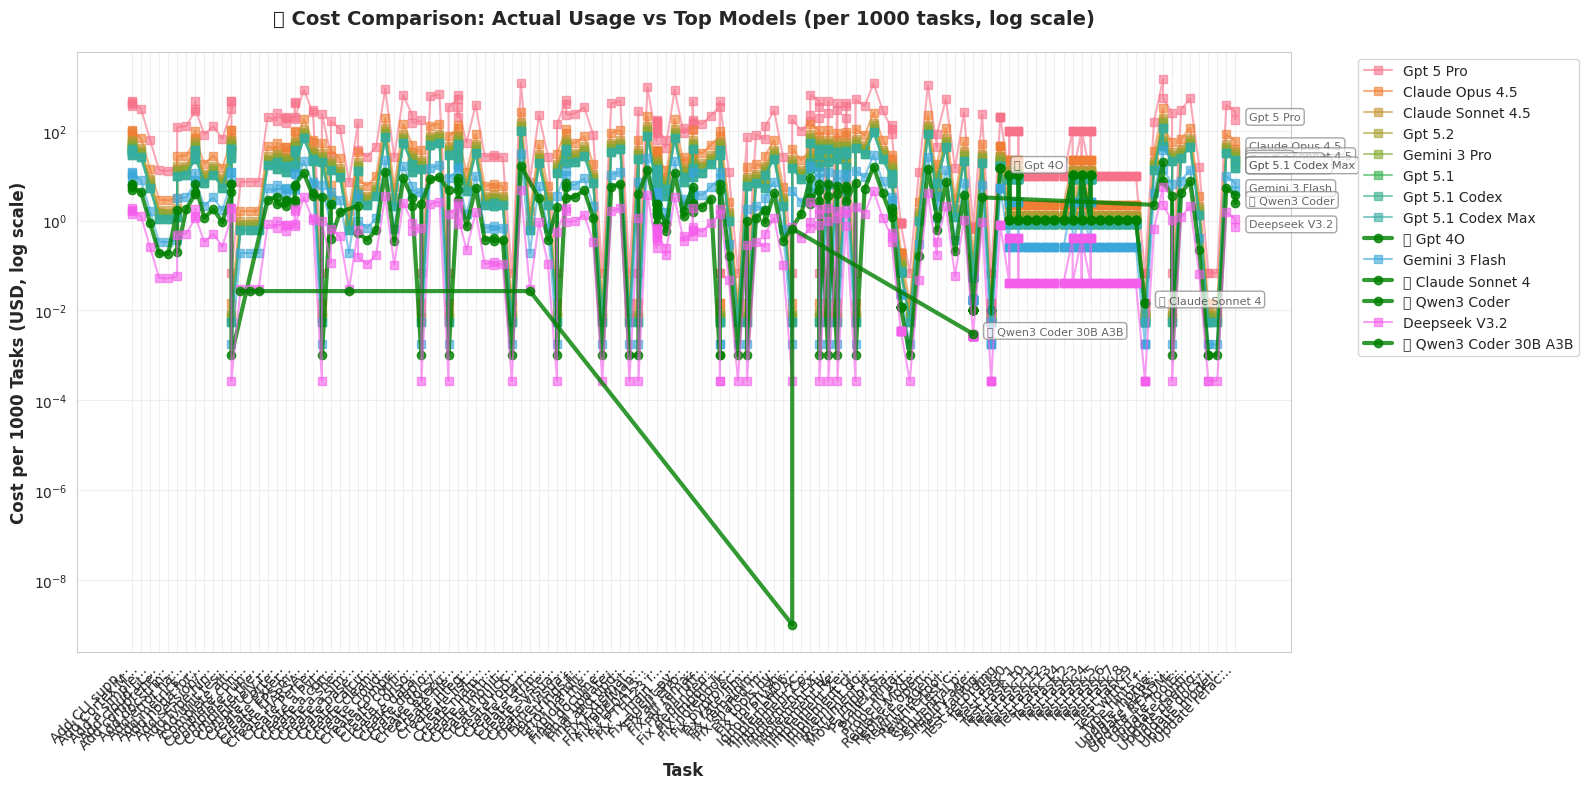


📊 Chart: cost comparison by task (scaled by 1000, log scale)


In [11]:

# Prepare data for plotting
plot_data = []

for _idx, row in df.iterrows():
    task_label = f"{row['Task']}"

    # Actual cost
    plot_data.append(
        {
            "Task": task_label,
            "Model": f"✅ {row['Used Model']}",
            "Cost": row["Actual Cost"],
            "Type": "Actual",
        }
    )

    # Top models costs
    for model_name in comparison_models:
        clean_name = unify_model_name(model_name)
        if clean_name in row:
            plot_data.append(
                {
                    "Task": task_label,
                    "Model": clean_name,
                    "Cost": row[clean_name],
                    "Type": "Alternative",
                }
            )

plot_df = pd.DataFrame(plot_data)

# Log scale can't display zeros/negatives. Add a tiny floor.
EPS = 1e-9
plot_df["Cost_plot"] = pd.to_numeric(plot_df["Cost"], errors="coerce").clip(lower=EPS)

# Create plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot lines for each model
models_to_plot = plot_df["Model"].unique()

# Sort models by average cost for better legend readability
model_avg_costs = plot_df.groupby("Model")["Cost_plot"].mean().sort_values(ascending=False)
models_to_plot = model_avg_costs.index.tolist()

colors = sns.color_palette("husl", len(models_to_plot))

for i, model in enumerate(models_to_plot):
    model_data = plot_df[plot_df["Model"] == model].sort_values("Task")

    if model.startswith("✅"):
        # Highlight actual model usage with thicker line
        ax.plot(
            model_data["Task"],
            model_data["Cost_plot"],
            marker="o",
            linewidth=3,
            label=model,
            color="green",
            alpha=0.8,
        )
    else:
        # Alternative models
        ax.plot(
            model_data["Task"],
            model_data["Cost_plot"],
            marker="s",
            linewidth=1.5,
            label=model,
            color=colors[i],
            alpha=0.6,
        )

    # Add label to the last point
    if len(model_data) > 0:
        last_task = model_data.iloc[-1]["Task"]
        last_cost = model_data.iloc[-1]["Cost_plot"]
        ax.annotate(
            model,
            xy=(last_task, last_cost),
            xytext=(10, 0),
            textcoords="offset points",
            fontsize=8,
            alpha=0.7,
            bbox={"boxstyle": "round,pad=0.3", "facecolor": "white", "edgecolor": "gray", "alpha": 0.7},
        )

ax.set_yscale("log")
ax.set_xlabel("Task", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Cost per {SCALE_FACTOR} Tasks (USD, log scale)", fontsize=12, fontweight="bold")
ax.set_title(
    f"💰 Cost Comparison: Actual Usage vs Top Models (per {SCALE_FACTOR} tasks, log scale)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
ax.grid(True, which="both", alpha=0.3)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(f"\n📊 Chart: cost comparison by task (scaled by {SCALE_FACTOR}, log scale)")

## 💵 Step 5: Calculate Total Savings

Calculate total savings compared to using top-5 models.

In [12]:
# Calculate savings vs each top model
total_actual_cost = df["Actual Cost"].sum()

print(f"\n💰 Total Savings Analysis (per {SCALE_FACTOR} tasks):")
print(f"\n{'Model':<40s} | {'Total Cost':>12s} | {'Savings':>12s} | {'% Saved':>8s}")
print("-" * 80)

# Show actual cost first
print(
    f"{'✅ Actual Usage (Mixed Models)':<40s} | ${total_actual_cost:>11.4f} | {'$0.0000':>12s} | {'0.0%':>8s}"
)
print("-" * 80)

# Compare vs top models
savings_data = []
for model_name in comparison_models:
    clean_name = unify_model_name(model_name)
    if clean_name in df.columns:
        total_if_used = df[clean_name].sum()
        savings = total_if_used - total_actual_cost
        savings_pct = (savings / total_if_used * 100) if total_if_used > 0 else 0

        savings_data.append(
            {
                "model": model_name,
                "clean_name": clean_name,
                "total_cost": total_if_used,
                "savings": savings,
                "savings_pct": savings_pct,
            }
        )

        print(
            f"{clean_name:<40s} | ${total_if_used:>11.4f} | ${savings:>11.4f} | {savings_pct:>7.1f}%"
        )

# Summary
if savings_data:
    avg_savings = sum(s["savings"] for s in savings_data) / len(savings_data)
    max_savings = max(savings_data, key=lambda x: x["savings"])

    print("\n" + "=" * 80)
    print(
        f"📊 Average savings vs top-5 models: ${avg_savings:.4f} ({avg_savings / total_actual_cost * 100:.1f}%)"
    )
    print(
        f"🏆 Best savings vs {max_savings['clean_name']}: ${max_savings['savings']:.4f} ({max_savings['savings_pct']:.1f}%)"
    )
    print("=" * 80)


💰 Total Savings Analysis (per 1000 tasks):

Model                                    |   Total Cost |      Savings |  % Saved
--------------------------------------------------------------------------------
✅ Actual Usage (Mixed Models)            | $   888.5540 |      $0.0000 |     0.0%
--------------------------------------------------------------------------------
Claude Opus 4.5                          | $  9585.3300 | $  8696.7760 |    90.7%
Gpt 5.1 Codex Max                        | $  3594.4987 | $  2705.9447 |    75.3%
Claude Sonnet 4.5                        | $  5751.1980 | $  4862.6440 |    84.6%
Gemini 3 Pro                             | $  4473.1540 | $  3584.6000 |    80.1%
Gpt 5.1                                  | $  3594.4987 | $  2705.9447 |    75.3%
Gpt 5.2                                  | $  5032.2982 | $  4143.7442 |    82.3%
Gpt 5.1 Codex                            | $  3594.4987 | $  2705.9447 |    75.3%
Gpt 5 Pro                                | $ 43133.9850

## 📋 Full Comparison Table

Complete table with all tasks and models.

In [13]:
# Format for better display
display_df = df.copy()

# Format cost columns to 6 decimal places
cost_columns = ["Actual Cost"] + [unify_model_name(m) for m in comparison_models]
for col in cost_columns:
    if col in display_df.columns:
        display_df[col] = display_df[col].apply(lambda x: f"${x:.6f}")

print(f"\n📋 Complete Cost Comparison Table (per {SCALE_FACTOR} tasks):")
print(display_df.to_string(index=False))


📋 Complete Cost Comparison Table (per 1000 tasks):
           Task                              Task ID          Used Model Actual Cost Claude Opus 4.5 Gpt 5.1 Codex Max Claude Sonnet 4.5 Gemini 3 Pro     Gpt 5.1     Gpt 5.2 Gpt 5.1 Codex    Gpt 5 Pro Deepseek V3.2 Gemini 3 Flash
Complete all... 596d6b76-0bed-42f3-9da2-bb8a5b473e26 Qwen3 Coder 30B A3B   $0.027000       $1.635000         $0.613125         $0.981000    $0.763000   $0.613125   $0.858375     $0.613125    $7.357500     $0.029648      $0.190750
Complete con... f8caed4a-1694-4d79-ba5d-258f23d79fca Qwen3 Coder 30B A3B   $0.027000       $1.635000         $0.613125         $0.981000    $0.763000   $0.613125   $0.858375     $0.613125    $7.357500     $0.029648      $0.190750
Complete run... a61b8740-edd1-4122-89ed-e83f210070ae Qwen3 Coder 30B A3B   $0.027000       $1.635000         $0.613125         $0.981000    $0.763000   $0.613125   $0.858375     $0.613125    $7.357500     $0.029648      $0.190750
Create root ... 0d69c971-944

## 🎯 Insights

**Key Findings:**
1. Using dynamic model selection based on task needs can significantly reduce costs
2. Not all tasks require the most expensive/capable models
3. Smart routing between models optimizes both cost and quality

**Limitations:**
- This analysis uses simplified cost calculations (same price for input/output)
- Doesn't account for differences in reasoning tokens between models
- Quality differences not reflected (some tasks may require smarter models)
- Real-world usage may vary based on task complexity